Updated analysis incorporating advise from coauthors.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
from astropy.timeseries import LombScargle
import scipy.signal as signal

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [13]:
tessfits = glob.glob('tess_fits_files/*fits')
tessfits

['tess_fits_files/tess2019226182529-s0015-0000000259773610-0151-s_lc.fits',
 'tess_fits_files/tess2019253231442-s0016-0000000259773610-0152-s_lc.fits']

In [105]:
#hard coding paths to sectors
s15fits = 'tess_fits_files/tess2019226182529-s0015-0000000259773610-0151-s_lc.fits'
s16fits = 'tess_fits_files/tess2019253231442-s0016-0000000259773610-0152-s_lc.fits'


/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


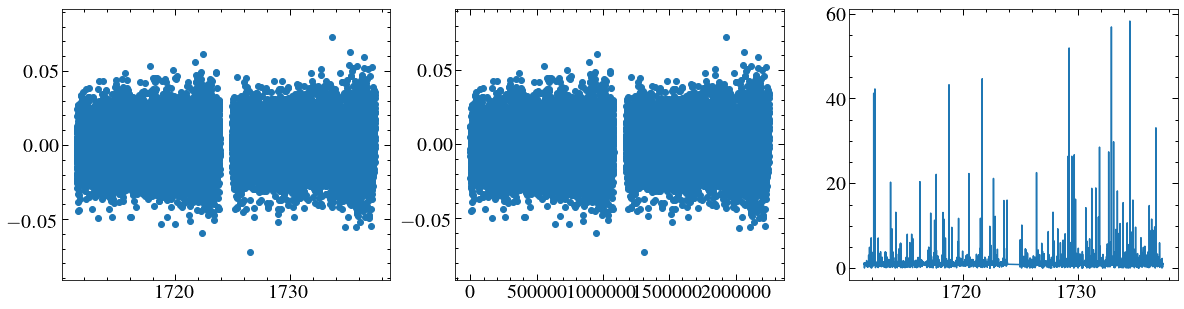

In [93]:
hdul = fits.open(tessfits[0])
data = hdul[1].data
plt.figure(figsize=(20, 5))

plt.subplot(131)
t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
crowdsap = hdul[1].header['CROWDSAP']
#f /= crowdsap
t, f, e = t[q==0], f[q==0], e[q==0]
fit = np.polyval((np.polyfit(t,f,2)), t)
f = (f/fit)-1
#f -= fit
e = (e/fit)-1
plt.scatter(t,f)
#plt.xlim(t[0], t[100])

plt.subplot(132)
jjt, jjf, jje = np.loadtxt('GD394.go.lc1', unpack=True)
plt.scatter(jjt, jjf)
#plt.xlim(jjt[0], jjt[100])

plt.subplot(133)
plt.plot(t, abs(f)/abs(jjf))
plt.show()
#hdul.close()

Differences are probably in the fit? Or the other thing JJ mentioned?  

Let's look at the background.

In [15]:
data.names

['TIME',
 'TIMECORR',
 'CADENCENO',
 'SAP_FLUX',
 'SAP_FLUX_ERR',
 'SAP_BKG',
 'SAP_BKG_ERR',
 'PDCSAP_FLUX',
 'PDCSAP_FLUX_ERR',
 'QUALITY',
 'PSF_CENTR1',
 'PSF_CENTR1_ERR',
 'PSF_CENTR2',
 'PSF_CENTR2_ERR',
 'MOM_CENTR1',
 'MOM_CENTR1_ERR',
 'MOM_CENTR2',
 'MOM_CENTR2_ERR',
 'POS_CORR1',
 'POS_CORR2']

/home/david/anaconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:108: LightkurveWarning: LightCurve object contains NaN times
  warnings.warn('LightCurve object contains NaN times', LightkurveWarning)
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less_equal
  


0.9977675262794609 d


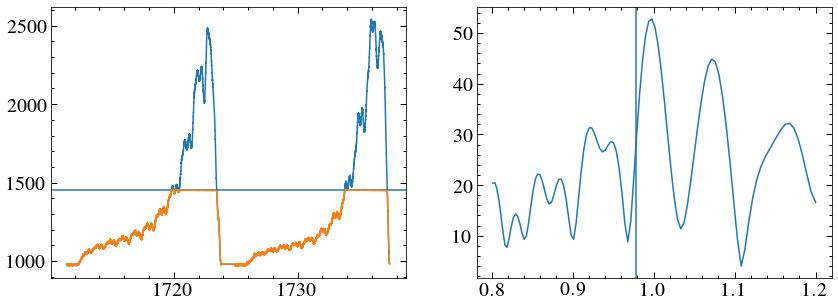

1.1827382285254915 d


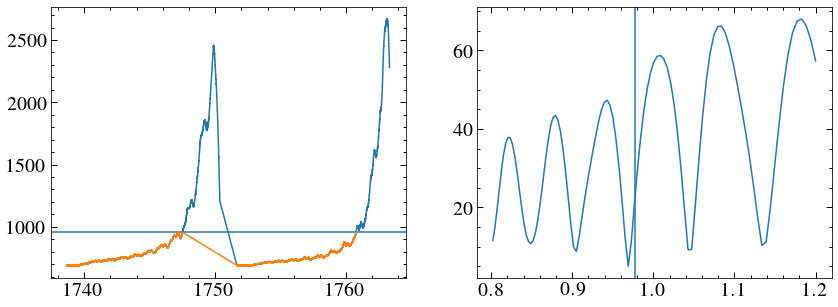

In [60]:
cut_times = []#times where bg > 1.1*median bg
for i, ft in enumerate(tessfits):
    plt.subplot(121)
    data = fits.getdata(ft, 1)
    lc = lk.LightCurve(time=data['TIME'], flux= data['SAP_BKG'])
    lc = lc.remove_nans()
    plt.plot(lc.time, lc.flux)
    #plt.axhline(np.median(lc.flux), c='g')
    #plt.axhline(1.1*np.median(lc.flux), c='r')
    #tind = np.where(lc.flux > 1.25*np.median(lc.flux))[0][0]
    #plt.axvline(lc.time[tind])
    cut = 1.25*np.median(lc.flux)
    plt.axhline(cut)
    mask =  (data['SAP_BKG'] <= cut)
    plt.plot(data['TIME'][mask], data['SAP_BKG'][mask])
   # plt.plot(data['TIME'], data['SAP_BKG'])
    
    plt.subplot(122)
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=0.8*u.day, maximum_period=1.2*u.day)
    plt.plot(pg.period, pg.power)
    #pg.plot()
    plt.axvline(0.9776875854871951)
    #plt.show()
    print(pg.period_at_max_power)
    plt.show()

How do the LS look using JJ lcs?

Parameter('fwhm', value=0.06244715052068569, unit=d)
Parameter('x_0', value=1.1441470739927595, unit=d) 0.0014258111721683385
Parameter('x_0', value=0.977554558325995, unit=d) 0.0014098896045141647
Parameter('fwhm', value=0.05223721912356787, unit=d)
Parameter('x_0', value=1.1543654820386422, unit=d) 0.0017686171286158264


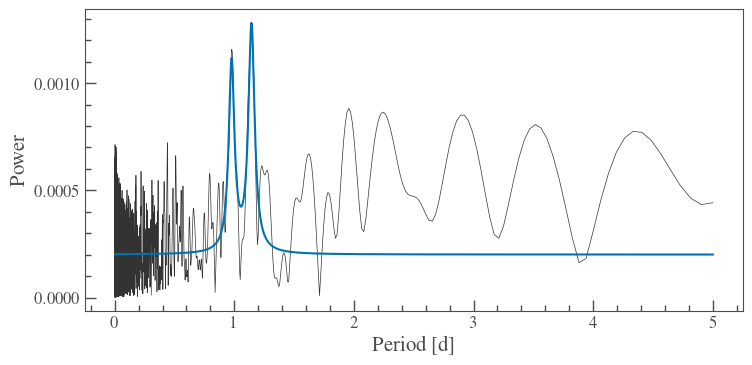

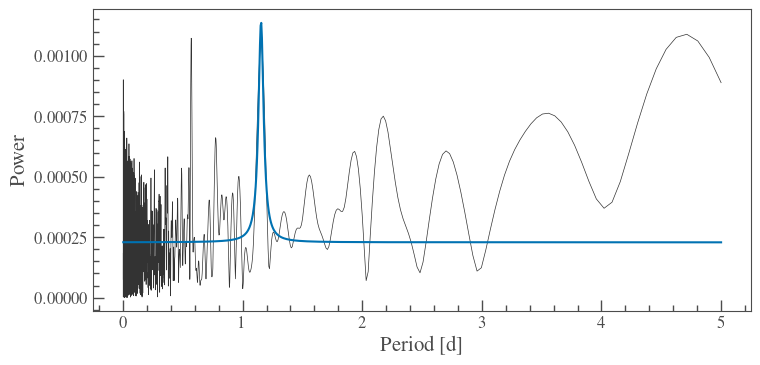

In [194]:
fitter = fitting.LevMarLSQFitter()

for i, ft in enumerate(tessfits):
    data = fits.getdata(ft, 1)
    t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
    t, f, e = t[q==0], f[q==0], e[q==0]
    fit = np.polyval((np.polyfit(t,f,2)), t)
    f = (f/fit)-1
    e = (e/fit)
    lc = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_outliers(sigma=5)
    if i == 0:
        lc15 = lc
    else:
        lc16= lc
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=5*u.day)
    pg.plot()
    l_init =  models.Lorentz1D(0.001, 1.15, fwhm=0.05)+models.Const1D(0)
    if i == 0:
        l_init += models.Lorentz1D(0.001, 0.9, fwhm=0.05)
    l_fit=fitter(l_init, pg.period, pg.power, maxiter=1000000)
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    print(l_fit[0].fwhm)
    print(l_fit[0].x_0, fit_e[1])
    if i == 0:
        print(l_fit[2].x_0, fit_e[5])
   # plt.axvline(0.98)
    plt.plot(pg.period, l_fit(pg.period))

And with background-cut lightcurves?

In [212]:
"""
for i, ft in enumerate(tessfits):
    plt.subplot(121)
    data = fits.getdata(ft, 1)
    t, f, e, q, bk = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY'], data['SAP_BKG']#[np.isnan(data['SAP_BKG'])==False]
    t, f, e, bk = t[q==0], f[q==0], e[q==0], bk[q==0]
    fit = np.polyval((np.polyfit(t,f,2)), t)
    f = (f/fit)-1
    e = (e/fit)
    cut_mask = (bk < 1.25*np.median(bk))
    lc = lk.LightCurve(time=t, flux=f, flux_err=e )#.remove_outliers(sigma=5)
    lc1 = lk.LightCurve(time=t[cut_mask], flux=f[cut_mask], flux_err=e[cut_mask] )
    #lcb = lk.LightCurve(time=t, flux=bk)
    plt.scatter(lc1.time, lc1.flux)
    #plt.scatter(lc1.time, lc1.flux_err)

    
   

 #   if i == 0:
  #      lc15 = lc
  #  else:
   #     lc16= lc
    
    plt.subplot(122)
    pg = lc1.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)
    #pg.plot()
    plt.plot(pg.period, pg.power)
    plt.axvline(1.14, c='C1')
    l_init =  models.Lorentz1D(0.001, 1.15, fwhm=0.05)+models.Const1D(0)
  #  if i == 0:
   #     l_init += models.Lorentz1D(0.001, 0.9, fwhm=0.05)
    l_fit=fitter(l_init, pg.period, pg.power, maxiter=1000000)
    #fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    #print(l_fit[0].fwhm)
    #print(l_fit[0].x_0, fit_e[1])
   # if i == 0:
    #    print(l_fit[2].x_0, fit_e[5])
   # plt.axvline(0.98)
    plt.plot(pg.period, l_fit(pg.period))
    plt.show()
"""

"\nfor i, ft in enumerate(tessfits):\n    plt.subplot(121)\n    data = fits.getdata(ft, 1)\n    t, f, e, q, bk = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY'], data['SAP_BKG']#[np.isnan(data['SAP_BKG'])==False]\n    t, f, e, bk = t[q==0], f[q==0], e[q==0], bk[q==0]\n    fit = np.polyval((np.polyfit(t,f,2)), t)\n    f = (f/fit)-1\n    e = (e/fit)\n    cut_mask = (bk < 1.25*np.median(bk))\n    lc = lk.LightCurve(time=t, flux=f, flux_err=e )#.remove_outliers(sigma=5)\n    lc1 = lk.LightCurve(time=t[cut_mask], flux=f[cut_mask], flux_err=e[cut_mask] )\n    #lcb = lk.LightCurve(time=t, flux=bk)\n    plt.scatter(lc1.time, lc1.flux)\n    #plt.scatter(lc1.time, lc1.flux_err)\n\n    \n   \n\n #   if i == 0:\n  #      lc15 = lc\n  #  else:\n   #     lc16= lc\n    \n    plt.subplot(122)\n    pg = lc1.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)\n    #pg.plot()\n    plt.plot(pg.period, pg.power)\n    plt.axvline(1.14, c='C1')

Don't think that worked very well. Let's go with the uncut lcs for now. Maybe make a plot to send to the TESS GO office.

In [94]:
"""
plt.figure(figsize=(18,6))
max_p = 3
min_p = 0.01
ys=[0.00001, 0.00145]
xs=[0.001, 2.99]

plt.subplot(121)
pg15 = lc15.to_periodogram(oversample_factor=10,minimum_period=min_p*u.day, maximum_period=max_p*u.day)
#pg_flat = lc15_flat.to_periodogram(oversample_factor=10,minimum_period=min_p*u.day, maximum_period=max_p*u.day)
plt.xlabel('Period (d)')
plt.ylabel('Power')
plt.annotate('Sector 15', (0.05, 0.9), xycoords='axes fraction')
plt.ylim(ys[0], ys[1])
plt.xlim(xs[0], xs[1])
plt.plot(pg15.period, pg15.power)
#plt.plot(pg_flat.period, pg_flat.power, ls='--', label='Suspected Earthshine Removed')
#plt.legend()


plt.subplot(122)
pg16 = lc16.to_periodogram(oversample_factor=10,minimum_period=min_p*u.day, maximum_period=max_p*u.day)
plt.plot(pg16.period, pg16.power)
plt.annotate('Sector 16', (0.05, 0.9), xycoords='axes fraction')
plt.xlabel('Period (d)')
plt.ylim(ys[0], ys[1])
plt.xlim(xs[0], xs[1])
plt.tight_layout()
plt.savefig('plots/djwilson_query_odd_period.pdf')
"""

"\nplt.figure(figsize=(18,6))\nmax_p = 3\nmin_p = 0.01\nys=[0.00001, 0.00145]\nxs=[0.001, 2.99]\n\nplt.subplot(121)\npg15 = lc15.to_periodogram(oversample_factor=10,minimum_period=min_p*u.day, maximum_period=max_p*u.day)\n#pg_flat = lc15_flat.to_periodogram(oversample_factor=10,minimum_period=min_p*u.day, maximum_period=max_p*u.day)\nplt.xlabel('Period (d)')\nplt.ylabel('Power')\nplt.annotate('Sector 15', (0.05, 0.9), xycoords='axes fraction')\nplt.ylim(ys[0], ys[1])\nplt.xlim(xs[0], xs[1])\nplt.plot(pg15.period, pg15.power)\n#plt.plot(pg_flat.period, pg_flat.power, ls='--', label='Suspected Earthshine Removed')\n#plt.legend()\n\n\nplt.subplot(122)\npg16 = lc16.to_periodogram(oversample_factor=10,minimum_period=min_p*u.day, maximum_period=max_p*u.day)\nplt.plot(pg16.period, pg16.power)\nplt.annotate('Sector 16', (0.05, 0.9), xycoords='axes fraction')\nplt.xlabel('Period (d)')\nplt.ylim(ys[0], ys[1])\nplt.xlim(xs[0], xs[1])\nplt.tight_layout()\nplt.savefig('plots/djwilson_query_odd_peri

Getting rid of the 0.98 d signal.

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          amplitude            frequency            phase       
    ---------------------- ------------------ ------------------
    -0.0011613152859176216 1.0207879324072944 3.0576743709083924
0.9796354054085742
[1.61570139e-04 2.85909526e-03 4.93035804e+00]


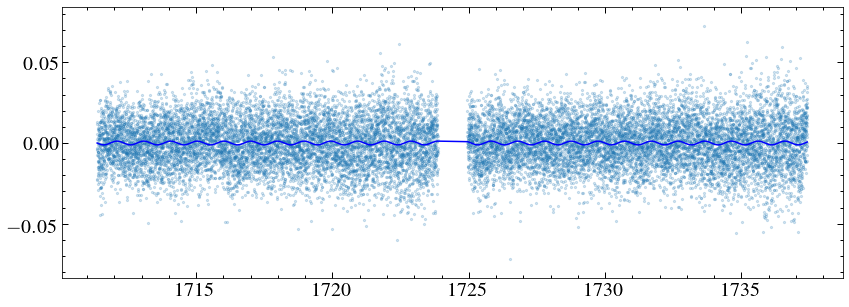

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          amplitude            frequency            phase       
    ---------------------- ------------------ ------------------
    -0.0011613152859176216 1.0207879324072944 3.0576743709083924


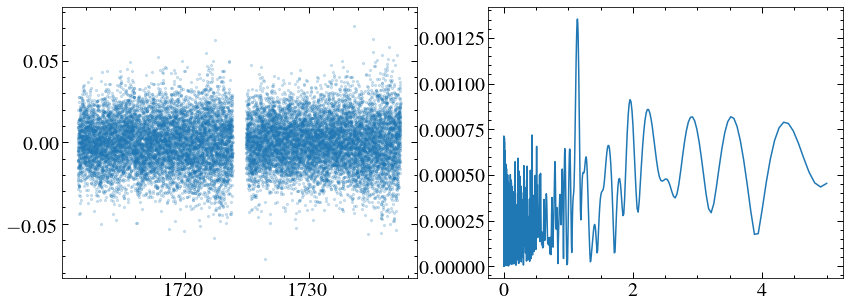

In [196]:
f_earth = 0.978
fitter = fitting.LevMarLSQFitter()
#lc_fold = lc15.fold(0.9776875854871951)#.bin(300)
#lc_fold.scatter()
#sin_mod =  models.Sine1D(amplitude=1, frequency=1, fixed={'frequency':1})#+models.Const1D(1.0, fixed={'amplitude':1.0})
#sin_fit = fitter(sin_mod, lc_fold.time, lc_fold.flux,  weights=1/lc_fold.flux_err, maxiter=100000)
#print(sin_fit)
#plt.plot(lc_fold.time, sin_fit(lc_fold.time), c='r')
#plt.show()
                                                          
#lc_bin = lc15.bin(90)
#lc_bin.scatter()
bg_mod =  models.Sine1D(amplitude=0.001, frequency=1/f_earth)#, bounds={'frequency':[1/(f_earth-e_earth), 1/(f_earth+e_earth)]})#+models.Const1D(1.0, fixed={'amplitude':1.0})
bg_fit = fitter(bg_mod, lc15.time, lc15.flux, maxiter=1000000)
print(bg_fit)
bg_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
#plt.plot(lc_bin.time, sin_fit(lc_bin.time), c='r')
#plt.scatter(lc15.time, lc15.flux)
plt.scatter(lc15.time, lc15.flux, s=5, rasterized=True, alpha=0.2) 
plt.plot(lc15.time, bg_fit(lc15.time), c='b') 
print(1/bg_fit.frequency)
print(bg_fit_e)
plt.show()


crowd = fits.getheader(s15fits,1)['CROWDSAP']
#bg_fit.amplitude = bg_fit.amplitude/crowd
print(bg_fit)

lc15_flat = lk.LightCurve(time=lc15.time, flux=lc15.flux-bg_fit(lc15.time), flux_err=lc15.flux_err)
plt.subplot(121)
plt.scatter(lc15_flat.time, lc15_flat.flux, s=5, rasterized=True, alpha=0.2) 
plt.subplot(122)
pg = lc15_flat.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=5*u.day)
plt.plot(pg.period, pg.power)

#lc15.fold(1/bg_fit.frequency).bin(20).scatter()

Adjusting the fit for CROWDSAP over-subtracts the signal - hint that it's background?

Doing both lcs separately

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude           frequency            phase       
    -------------------- ------------------ ------------------
    0.001356314820821409 0.8762030749036531 1.8246660534986703
Period = 1.141287937285497 0.003164761612111856
Amplitude = 0.001356314820821409 0.00016113693454848182
Adjusted Amplitide 0.002454177108952347 0.00029156842504761524
Phase = 1.8246660534986703 4.18979859242052
Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude           frequency            phase       
    -------------------- ------------------ ------------------
    0.001046654886023885 0.8658056443638982 19.942223351524063
Period = 1.1549936253126343 0.005013708286819811
Amplitude = 0.001046654886023885 0.00018214901670338306
Adjusted Amplitide 0.0017668851895364169 0.0003074904672011291
Phase = 19.942223351524063 6.581036708415894


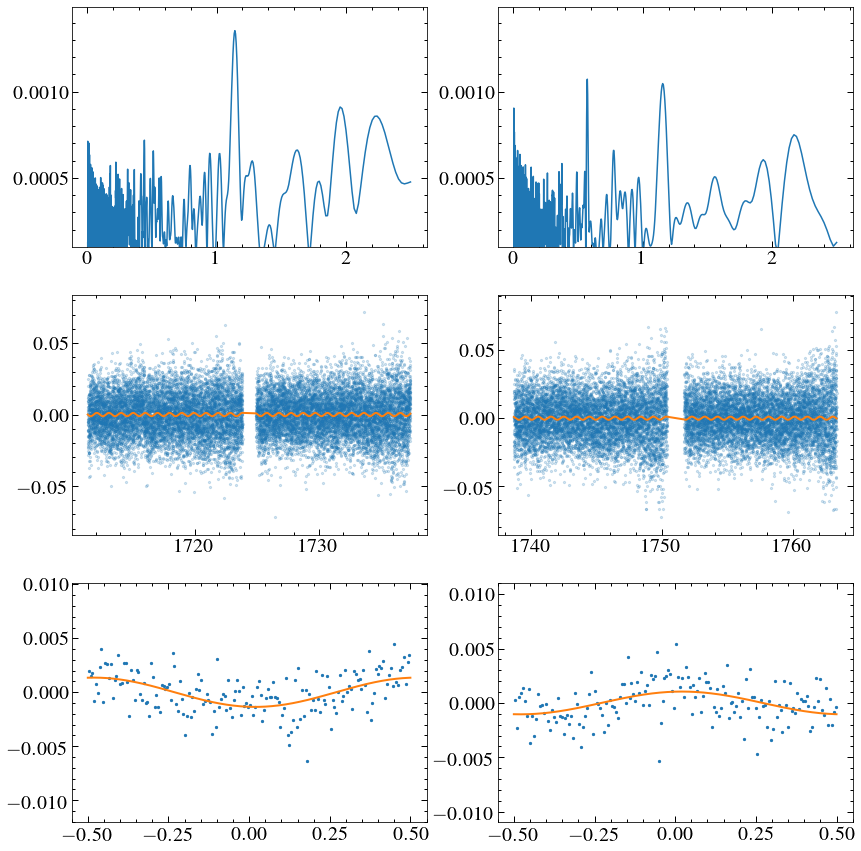

In [217]:
plt.figure(figsize=(14, 15))
for i, lc in enumerate([lc15_flat, lc16]):
    plt.subplot(3,2, i+1)
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)
    plt.plot(pg.period, pg.power)
    plt.ylim(0.0001, 0.00149)
    
    plt.subplot(3,2,i+3)
    sin_mod =  models.Sine1D(amplitude=0.001, frequency=1/1.14)
    sin_fit = fitter(sin_mod, lc.time, lc.flux)
    sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    plt.scatter(lc.time, lc.flux, s=5, rasterized=True, alpha=0.2) 
    plt.plot(lc.time, bg_fit(lc.time), c='C1', lw=2) 
    
    pbin =100
    plt.subplot(3,2,i+5)
    #if i == 0:
    t0 = lc.time[0]+(sin_fit.phase*sin_fit.frequency) #what phase to fold to
    
    
    lc_fold = lc.fold(1/sin_fit.frequency, t0 = t0)#.bin(50)
    #plt.scatter(lc_fold.time, lc_fold.flux, s=5, rasterized=True, alpha=0.2)
  #  plt.errorbar(lc_fold.bin(pbin).time, lc_fold.bin(pbin).flux, yerr=lc_fold.bin(pbin).flux_err, ls='none')
    plt.scatter(lc_fold.bin(pbin).time, lc_fold.bin(pbin).flux, s=5)
    
    fold_mod =  models.Sine1D(amplitude=0.001, frequency=1, fixed={'frequency':1})
    fold_fit = fitter(fold_mod, lc_fold.time, lc_fold.flux)
    plt.plot(lc_fold.time,fold_fit(lc_fold.time), c='C1', lw=2)
    
    
    print(sin_fit)
    print('Period =', 1/sin_fit.frequency.value, sin_fit_e[1]/(sin_fit.frequency.value**2))
    print('Amplitude =', sin_fit.amplitude.value, sin_fit_e[0])
    
    crowd = fits.getheader(tessfits[i],1)['CROWDSAP']
    
    print('Adjusted Amplitide', sin_fit.amplitude.value/crowd, sin_fit_e[0]/crowd)
    print('Phase =', sin_fit.phase.value, sin_fit_e[2])
    

In [185]:
#Period = 1.141287937285497 0.003164761612111856
#Adjusted Amplitide 0.002454177108952347 0.00029156842504761524
#Period = 1.1549936253126343 0.005013708286819811
#Adjusted Amplitide 0.0017668851895364169 0.0003074904672011291
p15, p15e = 1.14, 0.003
a15, a15e= 0.0025, 0.0003
p16, p16e = 1.155, 0.005
a16, a16e= 0.0018. 0.0003


In [187]:
#fits.getheader(tessfits[1])